# A basic CLIP model
In this notebook, we create a *very* basic contrastive learning model. It consists of 45 main components:
- A label encoder
- An image encoder
- A projection head
- The model
- A contrastive loss


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
DATA_PATH = '../data/'

In [52]:
digits_train = datasets.MNIST(DATA_PATH, train=True, download=True, transform=transforms.ToTensor())
digits_test = datasets.MNIST(DATA_PATH, train=False, download=True, transform=transforms.ToTensor())

digit_values = digits_train.data/255.
digit_labels = digits_train.targets

# onehot-encode labels
digit_labels_onehot = np.zeros((len(digit_labels), 10))
digit_labels_onehot[np.arange(len(digit_labels)), digit_labels] = 1

## Digit encoder
This is a simple convolutional network that takes a 28x28 image and outputs a 64-dimensional vector.

In [17]:
class DigitEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(392, 256),
            nn.SiLU(),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        return self.encoder(x)

## Label encoder
This is a simple feedforward network that takes a one-hot encoded label and outputs a 64-dimensional vector.

In [18]:
class LabelEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.GELU(),
            nn.Linear(16, 32),
            nn.GELU(),
            nn.Linear(32, 64)
        )

    def forward(self, x):
        return self.encoder(x)

## Projection head
Take the output of the encoders and project them to the final embedding space. We define this separately so that we can use whatever encoders we want.

In [19]:
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim=64, projection_dim=128):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout()
        self.l2_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.l2_norm(x)
        return x

## The final model

In [20]:
class BasicCLIP(nn.Module):
    def __init__(self):
        super().__init__()

        self.image_encoder = DigitEncoder()
        self.label_encoder = LabelEncoder()
        self.temperature = nn.Parameter(torch.tensor(np.log(1/0.07)))

        self.W_i = ProjectionHead(64, 128)
        self.W_t = ProjectionHead(64, 128)

    def forward(self, imgs, labels):
        I_f = self.image_encoder(imgs)
        T_f = self.label_encoder(labels)

        I_e = self.W_i(I_f)
        T_e = self.W_t(T_f)

        # l2 normalize
        I_e = F.normalize(I_e, p=2, dim=1)
        T_e = F.normalize(T_e, p=2, dim=1)

        logits = I_e @ T_e.T * self.temperature

        return logits

## Contrastive loss function

In [21]:
def loss_function(logits, N):
    loss_i = F.cross_entropy(logits, torch.arange(N))
    loss_t = F.cross_entropy(logits.T, torch.arange(N))

    loss = (loss_i + loss_t)/2

    return loss

## Training

In [22]:
BATCH_SIZE = 32
clip = BasicCLIP()
optimizer = optim.Adam(clip.parameters(), lr=0.0001)

for epoch in range(20):
    for i in tqdm(range(0, len(digit_values), BATCH_SIZE)):
        optimizer.zero_grad()
        input_image = digit_values[i:i+BATCH_SIZE].unsqueeze(1).float()
        input_label = torch.tensor(digit_labels_onehot[i:i+BATCH_SIZE]).float()

        logits = clip(input_image, input_label)

        loss = loss_function(logits, logits.shape[0])
        loss.backward()
        optimizer.step()

    if i % 1 == 0:
        print(f'Epoch {epoch} Iteration {i} Loss: {loss.item()}')

  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [00:08<00:00, 219.34it/s]


Epoch 0 Iteration 59968 Loss: 2.0738425254821777


100%|██████████| 1875/1875 [00:09<00:00, 190.84it/s]


Epoch 1 Iteration 59968 Loss: 1.8572027683258057


100%|██████████| 1875/1875 [00:07<00:00, 241.22it/s]


Epoch 2 Iteration 59968 Loss: 1.6539438962936401


100%|██████████| 1875/1875 [00:08<00:00, 224.16it/s]


Epoch 3 Iteration 59968 Loss: 1.5536744594573975


100%|██████████| 1875/1875 [00:10<00:00, 178.99it/s]


Epoch 4 Iteration 59968 Loss: 1.4917751550674438


100%|██████████| 1875/1875 [00:09<00:00, 206.85it/s]


Epoch 5 Iteration 59968 Loss: 1.4532601833343506


100%|██████████| 1875/1875 [00:08<00:00, 217.19it/s]


Epoch 6 Iteration 59968 Loss: 1.4193083047866821


100%|██████████| 1875/1875 [00:08<00:00, 228.10it/s]


Epoch 7 Iteration 59968 Loss: 1.3929462432861328


100%|██████████| 1875/1875 [00:07<00:00, 238.06it/s]


Epoch 8 Iteration 59968 Loss: 1.3707425594329834


100%|██████████| 1875/1875 [00:08<00:00, 218.65it/s]


Epoch 9 Iteration 59968 Loss: 1.3541414737701416


100%|██████████| 1875/1875 [00:09<00:00, 194.53it/s]


Epoch 10 Iteration 59968 Loss: 1.341842770576477


100%|██████████| 1875/1875 [00:09<00:00, 201.02it/s]


Epoch 11 Iteration 59968 Loss: 1.3326345682144165


100%|██████████| 1875/1875 [00:08<00:00, 220.47it/s]


Epoch 12 Iteration 59968 Loss: 1.3281161785125732


100%|██████████| 1875/1875 [00:08<00:00, 213.44it/s]


Epoch 13 Iteration 59968 Loss: 1.3154702186584473


100%|██████████| 1875/1875 [00:07<00:00, 235.64it/s]


Epoch 14 Iteration 59968 Loss: 1.2993686199188232


100%|██████████| 1875/1875 [00:08<00:00, 220.31it/s]


Epoch 15 Iteration 59968 Loss: 1.288424015045166


100%|██████████| 1875/1875 [00:08<00:00, 221.23it/s]


Epoch 16 Iteration 59968 Loss: 1.290971040725708


100%|██████████| 1875/1875 [00:09<00:00, 200.01it/s]


Epoch 17 Iteration 59968 Loss: 1.2828881740570068


100%|██████████| 1875/1875 [00:09<00:00, 205.20it/s]


Epoch 18 Iteration 59968 Loss: 1.2786535024642944


100%|██████████| 1875/1875 [00:08<00:00, 214.39it/s]

Epoch 19 Iteration 59968 Loss: 1.282941460609436


## Evaluate the model

In [23]:
test_digit_values = digits_test.data/255.
test_digit_labels = digits_test.targets

test_digit_labels_onehot = np.zeros((len(test_digit_labels), 10))
test_digit_labels_onehot[np.arange(len(test_digit_labels)), test_digit_labels] = 1

In [25]:
from tqdm import tqdm

test_labels_array = torch.tensor(np.arange(0,10,1))
test_labels_onehot = np.zeros((10, 10))
test_labels_onehot[np.arange(10), test_labels_array] = 1

# run through all testing examples
predictions = []
clip.eval()
with torch.no_grad():
    for image in tqdm(test_digit_values):
        image = image.unsqueeze(0).unsqueeze(0).float()
        label = torch.tensor(test_labels_onehot).float()
        output = clip(image, label)
        probs = torch.nn.functional.softmax(output, dim=1)
        # get max
        prediction = torch.argmax(probs.detach())
        predictions.append(prediction)

100%|██████████| 10000/10000 [00:14<00:00, 684.93it/s]


In [26]:
predictions = np.array(predictions)
real = test_digit_labels.numpy()
(predictions == real).sum() / len(real)

0.9816

In [27]:
# send the test digits through the encoder and get latent representations
encoder = clip.image_encoder

latent_representations = []
for image in tqdm(test_digit_values):
    image = image.unsqueeze(0).unsqueeze(0).float()
    latent = encoder(image)
    latent_representations.append(latent.detach().numpy())

100%|██████████| 10000/10000 [00:02<00:00, 3442.69it/s]


In [28]:
latent_representations = np.array(latent_representations).squeeze()

In [30]:
import matplotlib.pyplot as plt

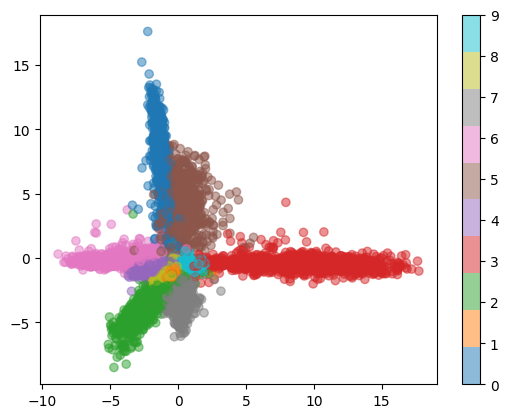

In [33]:
# pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler().fit_transform(latent_representations)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)
plt.scatter(pca_result[:,0], pca_result[:,1], c=test_digit_labels, cmap='tab10', alpha=0.5)
plt.colorbar()
plt.show()

# The logits for some examples
Here we get 10 examples from the training set and the corresponding labels. We then get the logits for these examples and plot them in a heatmap.

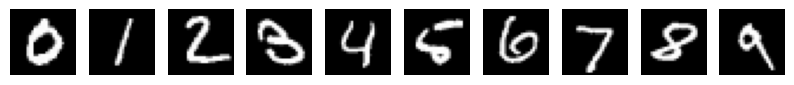

In [34]:
# get an example image from each class
example_images = []
for i in range(10):
    example_images.append(test_digit_values[test_digit_labels == i][0])

example_images = torch.stack(example_images).unsqueeze(1).float()

plt.figure(figsize=(10,10))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(example_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [36]:
one_hot_labels = np.zeros((10, 10))
one_hot_labels[np.arange(10), np.arange(10)] = 1

In [44]:
# get the logits
logits = clip(example_images, torch.tensor(one_hot_labels).float())

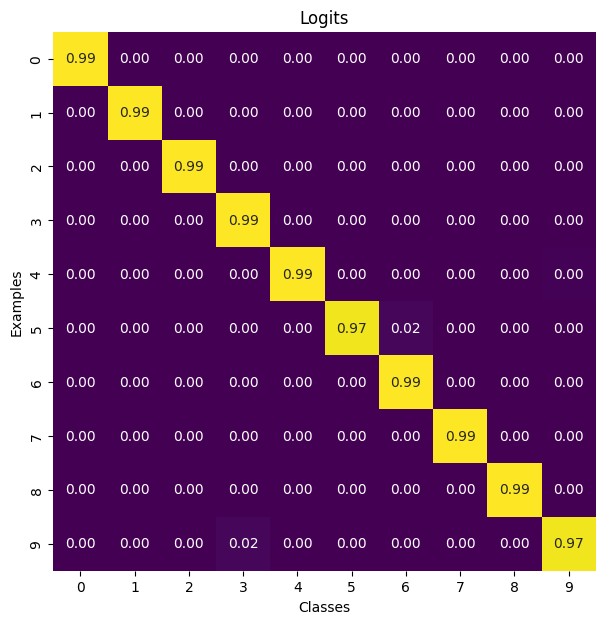

In [46]:
import seaborn as sns

# plot and force square
plt.figure(figsize=(7,7))

probs = F.softmax(logits, dim=1)
sns.heatmap(probs.detach().numpy(), cmap='viridis', cbar=False, annot=True, fmt='.2f')
plt.xlabel('Classes')
plt.ylabel('Examples')
plt.title('Logits')
plt.show()
